# Why does the Kepler pipeline find spurious TCEs at ~370 day periods?

The Kepler DR25 TCE list shows a spurious population of TCEs with periods close to 370 days, likely due to systematics. This notebook illustrates the issue and attempts to make a simple cut to identify the cadences and TCE's involved. 

First, let's load the Python modules we need:

In [2]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
import seaborn as sns

import numpy as np
import pandas as pd
import itertools
import tqdm

Let's load the DR25 TCE table, obtained from NexSCI. You can obtain this file using wget as follows:

    wget -O q1_q17_dr25_tce.csv "http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_tce&select=*"

In [4]:
# Read the TCE table
tcedf = pd.read_csv('../data/q1_q17_dr25_tce.csv')
# Add the unique TCE ID used by the RoboVetter output:
tcedf.loc[:, 'tce'] = ['{:09d}-{:02d}'.format(row.kepid, row.tce_plnt_num) for row in tcedf.itertuples()]

In [5]:
# A few useful constants
KEPLER_BEGIN_BK, KEPLER_END_BK = 130, 1582

## So, what does the period distribution of the DR25 TCE's look like?

Let's make a histogram!

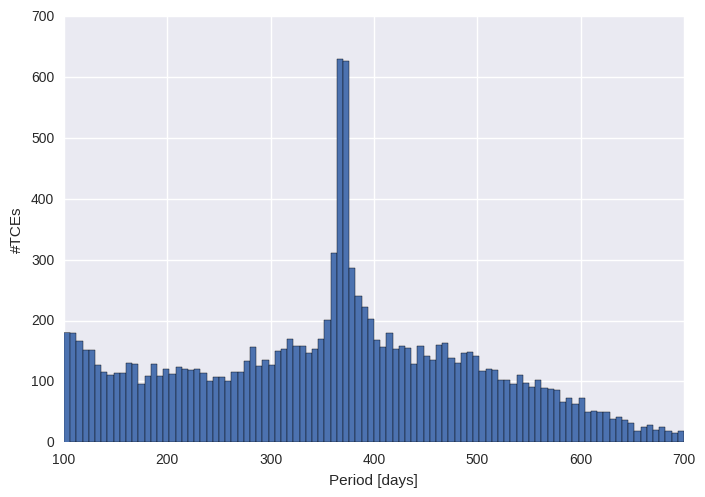

In [6]:
_ = pl.hist(tcedf.tce_period, range=(100, 700), bins=100)
pl.xlabel('Period [days]')
pl.ylabel('#TCEs')

Uh oh, there's a spurious peak near 370 days. Let's zoom in:

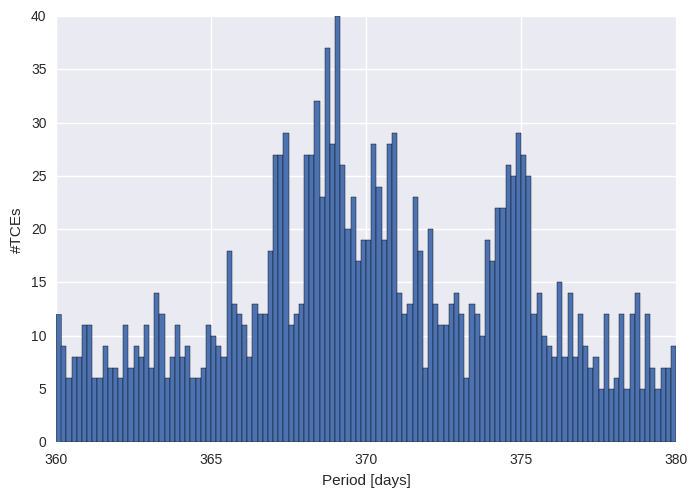

In [7]:
_ = pl.hist(tcedf.tce_period, range=(360, 380), bins=120)
pl.xlabel('Period [days]')
pl.ylabel('#TCEs')

Because these spurious TCEs all share a very similar period, it is likely that they relate to specific events. Let's have look at the transit times of these TCEs.

## When did the transits of these spurious TCE's occur?

We'll need a list of all the transit times for a set of TCE's.  We can create such lists using this function:

In [8]:
def get_transit_times(tcedf):
    """Returns a list containing the transit times of all TCE's passed as first argument."""
    transit_times = []
    for mytce in tcedf.itertuples():
        tce_transit_times = []
        mytime = mytce.tce_time0bk
        while mytime < KEPLER_END_BK:
            tce_transit_times.append(mytime)
            mytime += mytce.tce_period
        transit_times.append(tce_transit_times)
    return transit_times

Now let's use this function to show the distribution of transit times as a function of different TCE period bins:

6it [00:09,  1.44s/it]


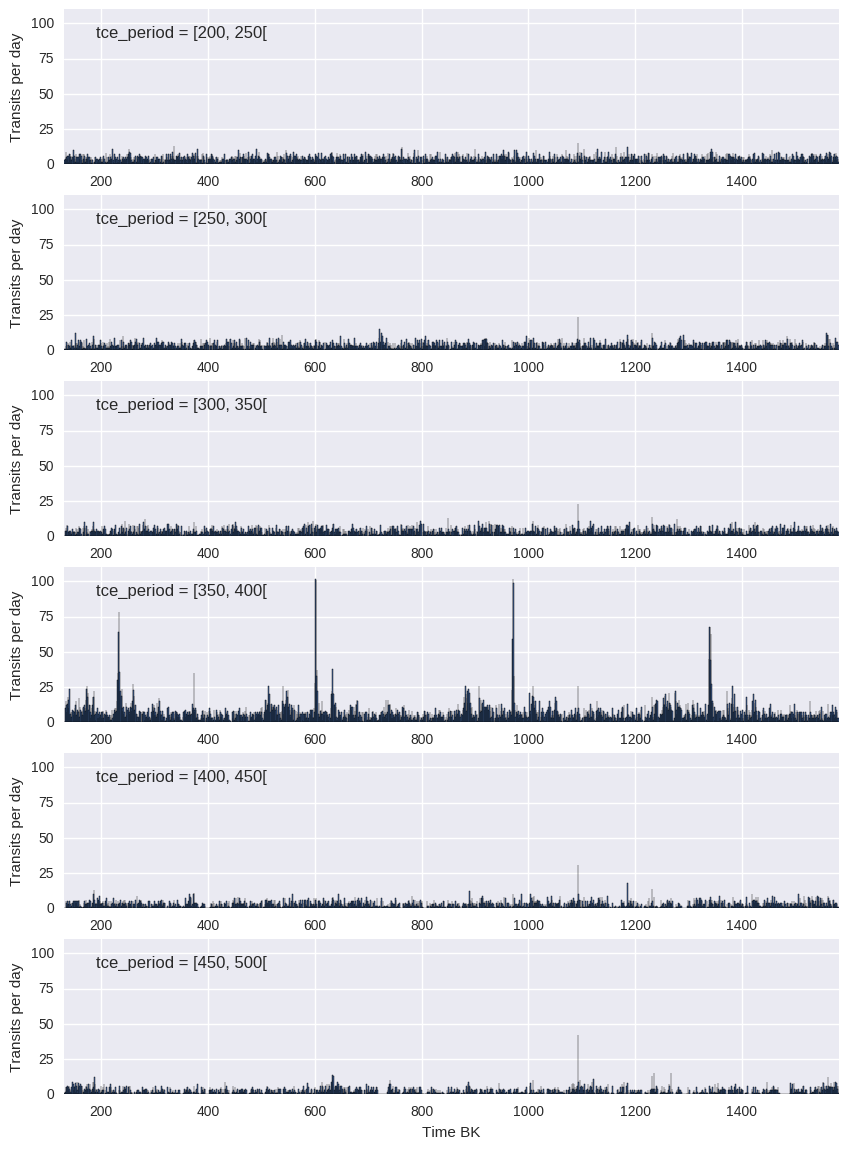

In [10]:
stepsize = 50
boundaries = range(200, 500, stepsize)
pl.figure(figsize=(10, 14))
for idx, bound in tqdm.tqdm(enumerate(boundaries)):
    mask = (tcedf.tce_period >= bound) & (tcedf.tce_period < bound + stepsize)
    tt = get_transit_times(tcedf[mask])
    tt_flat = list(itertools.chain.from_iterable(tt))
    pl.subplot(len(boundaries), 1, idx+1)
    _ = pl.hist(tt_flat, range=(KEPLER_BEGIN_BK, KEPLER_END_BK), bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))  # 1 bin per day
    pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
    pl.ylim([0, 110])
    pl.yticks(range(0, 101, 25))
    pl.text(190, 90, 'tce_period = [{}, {}['.format(bound, bound+stepsize))
    pl.ylabel('Transits per day')
pl.xlabel('Time BK')

Oh wow, all the spurious transits appear to occur for TCE's with periods in the range [350, 400].  Let's zoom in on this range using more narrow period bins:

7it [00:13,  2.10s/it]


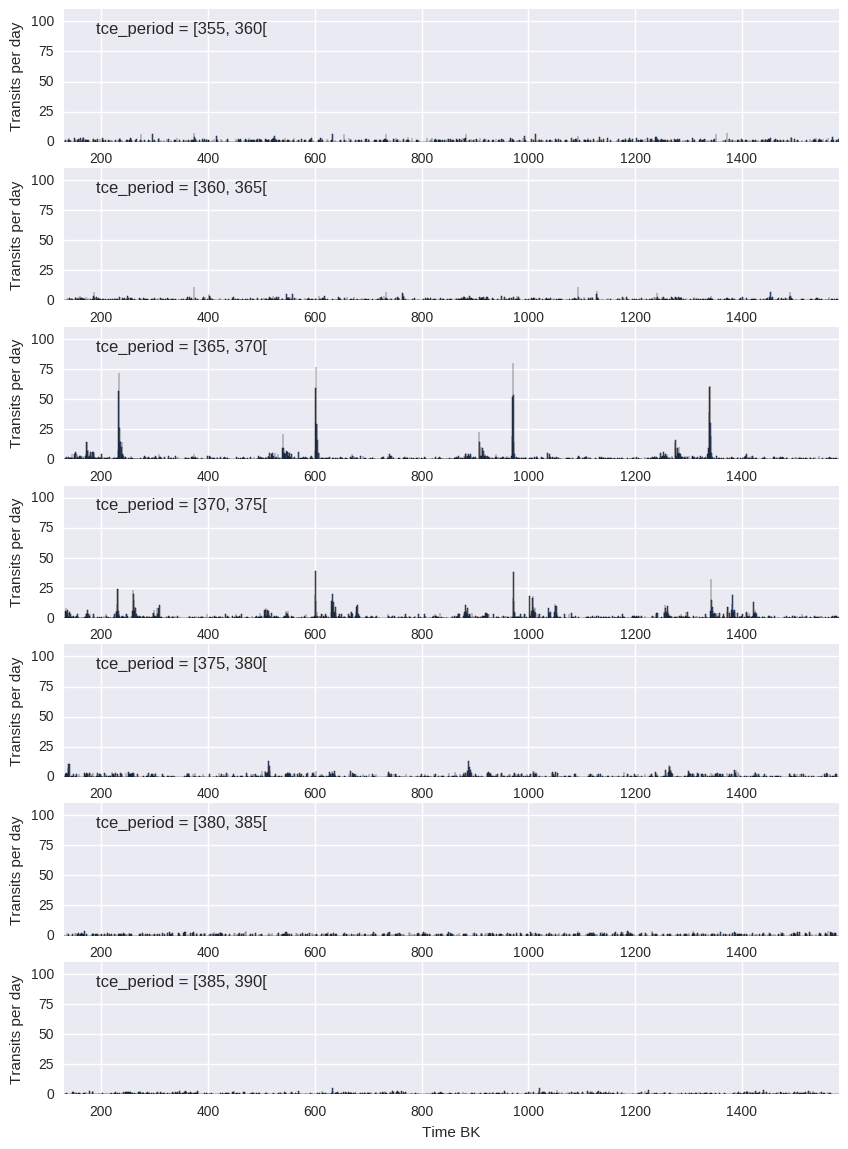

In [12]:
stepsize = 5
boundaries = range(355, 390, stepsize)
pl.figure(figsize=(10, 14))
for idx, bound in tqdm.tqdm(enumerate(boundaries)):
    mask = (tcedf.tce_period >= bound) & (tcedf.tce_period < bound + stepsize)
    tt = get_transit_times(tcedf[mask])
    tt_flat = list(itertools.chain.from_iterable(tt))
    pl.subplot(len(boundaries), 1, idx+1)
    _ = pl.hist(tt_flat, range=(KEPLER_BEGIN_BK, KEPLER_END_BK), bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))  # 1 bin per day
    pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
    pl.ylim([0, 110])
    pl.yticks(range(0, 101, 25))
    pl.text(190, 90, 'tce_period = [{}, {}['.format(bound, bound+stepsize))
    pl.ylabel('Transits per day')
pl.xlabel('Time BK')

## Which are the TCE's involved?

To understand the transit events that are likely spurious, let's make a list of the TCE's that show one or more transits at the spurious peaks.

Informed by the histograms above, let's narrow down the TCE selection to those showing periods in the range [365, 380]:

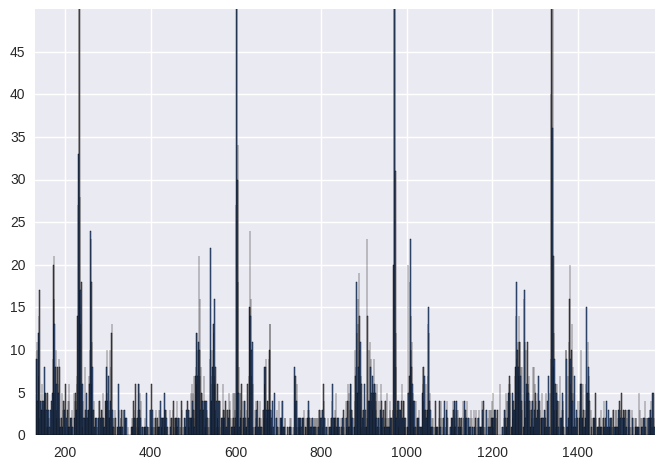

In [14]:
mask = (tcedf.tce_period >= 365) & (tcedf.tce_period < 380)
longperiod_tces = tcedf[mask].copy()
longperiod_tces.loc[:, 'tt'] = get_transit_times(longperiod_tces)
tt_flat = list(itertools.chain.from_iterable(longperiod_tces.tt))
transits, timebk, _ = pl.hist(tt_flat, range=(KEPLER_BEGIN_BK, KEPLER_END_BK), bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))
_ = pl.yticks(range(0, 50, 5))
_ = pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
_ = pl.ylim([0, 50])

Let's define the days that show transits for 8 or more long-period TCE's as "bad days":

In [16]:
bad_days = np.array(timebk[:-1][transits > 8], dtype=int)
print('Found {} bad days'.format(len(bad_days)))
print(bad_days)

Found 129 bad days
[ 132  133  134  136  137  138  140  171  172  173  174  175  178  185  229
  230  231  232  233  234  235  236  237  238  258  259  260  261  263  298
  304  308  309  507  508  511  512  513  514  515  539  540  541  546  547
  548  549  600  601  602  603  604  605  631  632  633  634  635  636  638
  670  677  678  679  680  879  882  883  885  886  888  889  890  891  907
  908  911  914  916  923  969  970  971  972  973  974 1002 1007 1008 1009
 1010 1012 1050 1051 1052 1256 1257 1258 1259 1260 1263 1264 1265 1274 1275
 1276 1279 1282 1337 1338 1339 1340 1341 1342 1343 1345 1346 1372 1373 1374
 1380 1381 1382 1383 1385 1386 1408 1421 1424]


Assuming all the TCE's with a transit on one of the above bad days are spurious, let's build an initial list of spurious TCE's:

In [17]:
bad_planets = []
for row in longperiod_tces.itertuples():
    for mytime in row.tt:
        if int(mytime) in bad_days:
            bad_planets.append(row.tce)
            break
print('{} out of {} long-period TCEs transit on the suspicious days.'.format(len(bad_planets), len(longperiod_tces)))

904 out of 1420 long-period TCEs transit on the suspicious days.


Write these TCE's to a text file.

In [19]:
baddf = pd.DataFrame({'tce': bad_planets})
with open('bad-tces.txt', 'w') as out:
    out.write('\n'.join(bad_planets))

## Compare to the RoboVetter output

In [124]:
robodf = pd.read_fwf('../data/RoboVetterOut-OPS-vDR24.txt', comment='#', names=('tce', 'score', 'disp', 'transitflag', 'secondaryflag', 'centroidflag', 'ephemerisflag', 'minorflags'))

In [125]:
merged = pd.merge(baddf, robodf, on='tce', how='left')
assert(len(merged) == len(baddf))

In [126]:
merged.disp.value_counts()

FP    859
PC     45
Name: disp, dtype: int64

In [127]:
merged.ephemerisflag.value_counts()

0    713
1    191
Name: ephemerisflag, dtype: int64

In [128]:
merged.transitflag.value_counts()

1    846
0     58
Name: transitflag, dtype: int64

## What does the RoboVetter Planet Candidate period distribution look like?

In [129]:
robomergedf = pd.merge(tcedf, robodf, on='tce')
assert(len(robomergedf) == len(robodf))
assert(len(robomergedf) == len(tcedf))

In [130]:
mask_pc = robomergedf.disp == 'PC'
mask_pc.sum()

4448

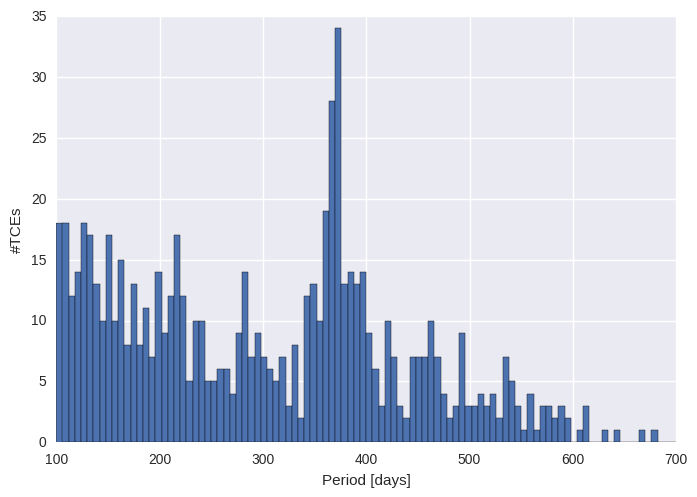

In [131]:
_ = pl.hist(robomergedf.tce_period[mask_pc], range=(100, 700), bins=100)
pl.xlabel('Period [days]')
pl.ylabel('#TCEs')

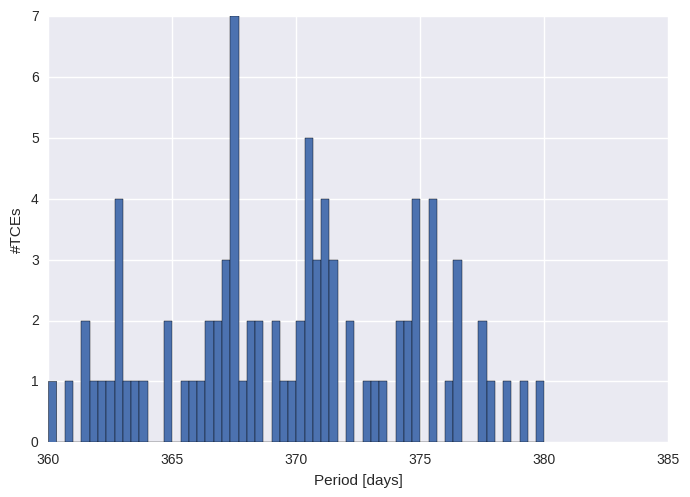

In [132]:
_ = pl.hist(robomergedf.tce_period[mask_pc], range=(360, 380), bins=60)
pl.xlabel('Period [days]')
pl.ylabel('#TCEs')

No, there's still a bump! Let's redo the analysis only for PC.

## Do the remaining Planet Candidates in the bump show correlated transit times?

7it [00:15,  2.31s/it]


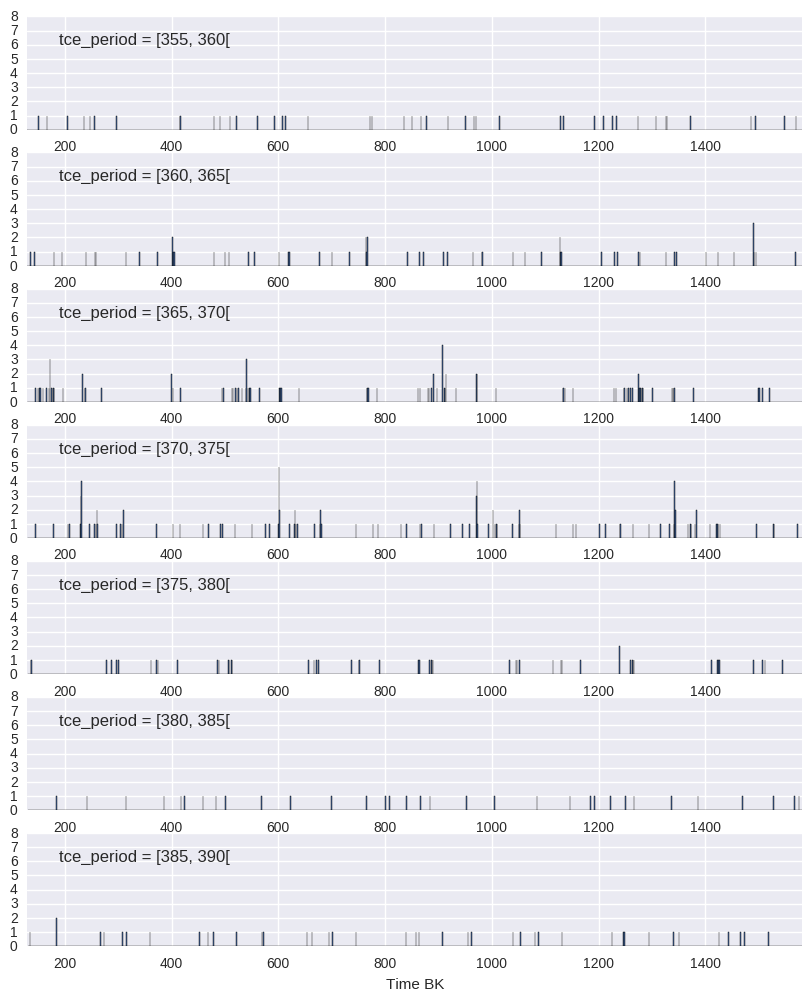

In [133]:
stepsize = 5
boundaries = range(355, 390, stepsize)
pl.figure(figsize=(10, 12))
for idx, bound in tqdm.tqdm(enumerate(boundaries)):
    mask = mask_pc & (robomergedf.tce_period >= bound) & (robomergedf.tce_period < bound + stepsize)
    tt = get_transit_times(robomergedf[mask])
    tt_flat = list(itertools.chain.from_iterable(tt))
    pl.subplot(len(boundaries), 1, idx+1)
    _ = pl.hist(tt_flat, range=(KEPLER_BEGIN_BK, KEPLER_END_BK), bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))  # 1 bin per day
    pl.xlim([KEPLER_BEGIN_BK, KEPLER_END_BK])
    pl.ylim([0, 8])
    #pl.yticks(range(0,101,25))
    pl.text(190, 6, 'tce_period = [{}, {}['.format(bound, bound+stepsize))
pl.xlabel('Time BK')

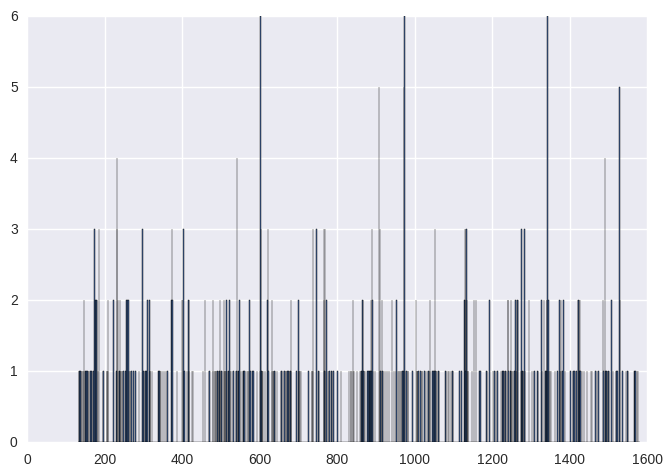

In [134]:
mask = mask_pc & (robomergedf.tce_period >= 350) & (robomergedf.tce_period < 400)
longperiod_pcs = robomergedf[mask].copy()
longperiod_pcs.loc[:, 'tt'] = get_transit_times(longperiod_pcs)
tt_flat = list(itertools.chain.from_iterable(longperiod_pcs.tt))
longperiod_pc_transits, longperiod_pc_timebk, _ = pl.hist(tt_flat, range=(KEPLER_BEGIN_BK, KEPLER_END_BK), bins=(KEPLER_END_BK - KEPLER_BEGIN_BK))

In [135]:
bad_days = np.array(longperiod_pc_timebk[:-1][longperiod_pc_transits > 4], dtype=int)
print(bad_days)

[ 601  907  971  972 1342 1527]


In [136]:
bad_planets = []
for row in longperiod_pcs.itertuples():
    for mytime in row.tt:
        if int(mytime) in bad_days:
            bad_planets.append('{:09d}-{:02d}'.format(row.kepid, row.tce_plnt_num))
            break
len(bad_planets)

24

In [137]:
bad_planets

['006128970-01',
 '007513516-03',
 '007340624-01',
 '007365910-01',
 '007762153-01',
 '007691691-01',
 '007618540-01',
 '007618641-01',
 '008239980-01',
 '008104824-01',
 '008035587-01',
 '008546512-01',
 '008879302-01',
 '008806998-01',
 '008870293-01',
 '008805005-01',
 '008870839-01',
 '010337859-02',
 '010671402-04',
 '011661803-04',
 '012164840-01',
 '011820346-01',
 '011868738-01',
 '012068524-01']